In [1]:
# Import the necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

In [2]:
# Creating the Convolutional Neural Network

class RiceCNN(nn.Module): # The RiceCNN itself is a class
    def __init__(self): # The first method in the RiceCNN class defines the different layers of the CNN
        super(RiceCNN, self).__init__() # This initializes the parent class "nn.Module" for this particular instance of our subclass "RiceCNN"
        
        # Create the 2D convolutional layers - 2D is for images, as opposed to 3D which would be used for videos or volumetric scans
        # I'll start with 2 convolutional layers and adjust for performance as needed
        
        # Convolutional layer 1
        self.conv1 = nn.Conv2d(in_channels=3, # 1 = greyscale, 2 = RGB, and 3 = multi-channel/hyperspectral
                               out_channels=32, # The number of feature maps produced, or "depth" of the network. More gives better results (to a point) and is more computationally intensive. Fewer runs faster, but give less detail
                               kernel_size=3, # The size of the convolutional matrix (filter) passed over the input, whether 2D or 3D. In this case, the kernel is 3x3 pixels
                               stride=1, # The number of pixels traversed each time the kernel moves across the input image during convolution
                               padding=1) # The number of extra pixels inserted as a boarder to the original input images. This "padding" helps preserve spacial dimensions
        
        # Convolutional layer 2
        self.conv2 = nn.Conv2d(in_channels=32, # Since we output 32 feature maps from our first convolutional layer, we must set our input as 32 for the second. These must always match
                               out_channels=64, # Increases the complexity and abstraction for better feature detecion
                               kernel_size=3, #|
                               stride=1,      # } These remain the same for now
                               padding=1)     #|
        
        # Convolutional layer 3
        self.conv3 = nn.Conv2d(in_channels=64,
                               out_channels=128,
                               kernel_size=3,
                               stride=1,
                               padding=1)

        # Now I'll create the max pooling layer. Max pooling reduces the spacial dimensions of the feature maps by sliding a kernel across them and taking the largest value
        # This dimensionality reduction preserves key features of the input image while reducing both the computational requirements and the chance of overfitting
        
        # Max pooling layer (2D, like our input images)
        self.pool = nn.MaxPool2d(kernel_size=2, # Smaller kernel size means a more detailed look at the original image, larger means a more agressive dimensionality reduction and less detail
                                 stride=2, # Stride matching the kernel size means there is no overlap or gapping as the kernel passes over the feature map, reducing the size by 1/2. This is called down-sampling
                                 padding=0) # No padding means we only consider the original feature map dimensions
        
        # Finally, I'll create the fully connected layers. These layers transform the high-dimensional feature maps into class predictions
        # It does this by performing linear transformation on flattened feature vectors, introducing non-linearity, and outputting class probabilities
        
        # Fully connected layer 1
        self.fc1 = nn.Linear(128 * 16 * 16, # Here we are declaring the size of each feature map output by the convolutional layers. 64 is the number of ouput channels from conv2, and padding-1, step=1 cuts that in half to 32x32
                             256) # This is the number of neurons in the fully connected layer. It determines the model's ability to learn from the data. Larger numbers increase the model's capacity to learn details, but risk overfitting
        
        # Fully connected layer 2
        self.fc2 = nn.Linear(256, # In the first fully connected layer, 64 represented the number of neurons comming in. Here again, 128 represents the number of neurons comming into the second fully connected layer from the first
                             5) # This is the number of output classes. Becuse my image sets contain 5 different varieties of rice, I have 5 possible output classes
        
    def forward(self, x): # The second method of the RiceCNN defines the forward pass of the data through the neural network. "self" represents this instance of the model, and "x" represents the image to be passed through the neural network
        x = F.relu(self.conv1(x)) # The original image is passed through the first convolutional layer. The Rectified Linear Unit (ReLU) activation function is used to introduce non-linearity 
        x = self.pool(x) # After passing through the first convolutional layer, max pooling reduces dimensionality
        x = F.relu(self.conv2(x)) # The resultant feature maps are passed through the second convolutional layer
        x = self.pool(x) # Max pooling is again used to reduce dimensionality
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        # Now that the image has passed through the convolutional layers, we will reshape it into a flat vector and pass it through the fully connected layers for classification
        
        x = x.view(-1, # Here, -1 is used to infer the number of images being processed, and therefore the number of tensors. If I knew I was only processessing 32 images, I could explicitly write is as "32". For flexibility, I use -1 to infer from the dataset
                   128 * 16 * 16) # Like before, I am declaring that there are 64 neurons input to the first fully connected layer and the parameters in conv2 cut that in half to 32x32
        x = F.relu(self.fc1(x)) # The 1D tensors are passed through the first fully connected layer
        x = self.fc2(x) # Finally, the output from the first fully connected payer is passed through the second fully connected layer to produce an image classification
        
        return(x) # This returns the image classification as one of the 5 possible rice varieties
    
# Finally, we can print the model to see a synopsis of the different layers and their parameters
model = RiceCNN()
print(model)

RiceCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=5, bias=True)
)


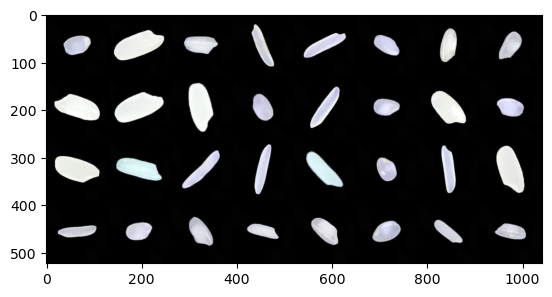

Karacadag Ipsala Arborio Basmati Basmati Karacadag Arborio Arborio


In [3]:
# Here we will load and transforms the images so we can use them to train the CNN
transform = transforms.Compose([
    transforms.Resize((128, 128)), # The native size of these images is 250x250. Downsizing aids in faster training, helps avoid overfitting, and acts as a normalizing step if the original images are different sizes
    transforms.ToTensor(), # Here we convert the image to a multi-dimensional PyTorch tensor that can be processed by the deep learning model. This normalizes the images to a range of [0, 1]
    # The following line would normalize the pixel values to [-1, 1], which would be ideal for a hyperbolic tangent activation function. Since we are using ReLU, it's better to normalize to [0, 1], so we'll comment it out
    # transforms.Normalize(mean=[0.5], std=[0.5]) 
])

# Designate the path to the data
path = r'~/Projects/DataSets/Rice_Image_Dataset' # Designate your own path

# Load the data
dataset = datasets.ImageFolder(root=path, transform=transform) # Here I've told PyTorch where to find the folders for each different rice species, and used the 'transform' parameter to tell it what to do with the images once it gets there

# Split the data into train and test sets
train_size = int(0.8 * len(dataset)) # The training set is 80% of the data
test_size = len(dataset) - train_size # The test set is the remaning 20%
train, test = torch.utils.data.random_split(dataset, [train_size, test_size]) # This is where we actually split the data into train and test sets. The random_split() parameters dictate the data to use and the sizes of the train and test sets

# Create the data loaders. Dataloaders provide an efficient way to iterate over the data in batches
train_loader = DataLoader(train, batch_size=32, shuffle=True) # Declaring that we will iterate over the training data in batches of 32 images, shuffling through the images randomly as we go
test_loader = DataLoader(test, batch_size=32, shuffle=False) # Declaring that we will iterate over the test data in batches of 32, but do so in order - not shuffling

# Verify the dataset is loaded properly
def show_image(img):
    # If we'd normalized to [-1, 1] for use with a tanh activation function, the following line would be necessary to de-normalize the images before visualizing. Since we're normalized to a range of [0, 1], this line is unnecessary and commented out
    # img = img / 2 + 0.5
    npimg = img.numpy() # Since we are visualizing the images with matplotlib, we need to convert the image from a PyTorch tensor to a NumPy array.
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # PyTorch tensors have the shape (C, H, W). C = channels (RGB), H = height, W = width. Matplotlib expects the shape to be (H, W, C). np.transpose() reorders the dimensions
    plt.show() # Display the images
    
# Get some training images
dataiter = iter(train_loader) # Here we convert our dataloader into an iterator
images, labels = next(dataiter) # Iterate over the batches of 32 images using the next() function. 'images' will be a tensor containing a batch of images, and 'labels' will be a tensor containing the corresponding labels

# Show images
show_image(torchvision.utils.make_grid(images)) # torchvision.utils.make_grid() takes a random batch of 32 images and displays it as a grid

# Print labels
print(' '.join(f'{dataset.classes[labels[j]]}' for j in range(8))) # This takes the 'labels' portion from the iterator and prints them out sparated by a space. They represent the top row of images in the grid.

In [4]:
# Now that we've built the model and loaded the data, it's time to define the loss function and optimizer
criterion = nn.CrossEntropyLoss() # Cross entropy loss is a common and effective loss function for classification problems with several classes

# We use Adam as the optimizer becasue it's efficient and performant over a wide range of tasks
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # model.parameters() iterates over the parameters in each of the layers (conv2d and fc), and lr=0.001 controls the learning rate 

Epoch [1/10], Loss: 0.1225
Epoch [2/10], Loss: 0.0360
Epoch [3/10], Loss: 0.0242
Epoch [4/10], Loss: 0.0196
Epoch [5/10], Loss: 0.0148
Epoch [6/10], Loss: 0.0164
Epoch [7/10], Loss: 0.0125
Epoch [8/10], Loss: 0.0116
Epoch [9/10], Loss: 0.0101
Epoch [10/10], Loss: 0.0103
The model has finished training. Plotting loss.


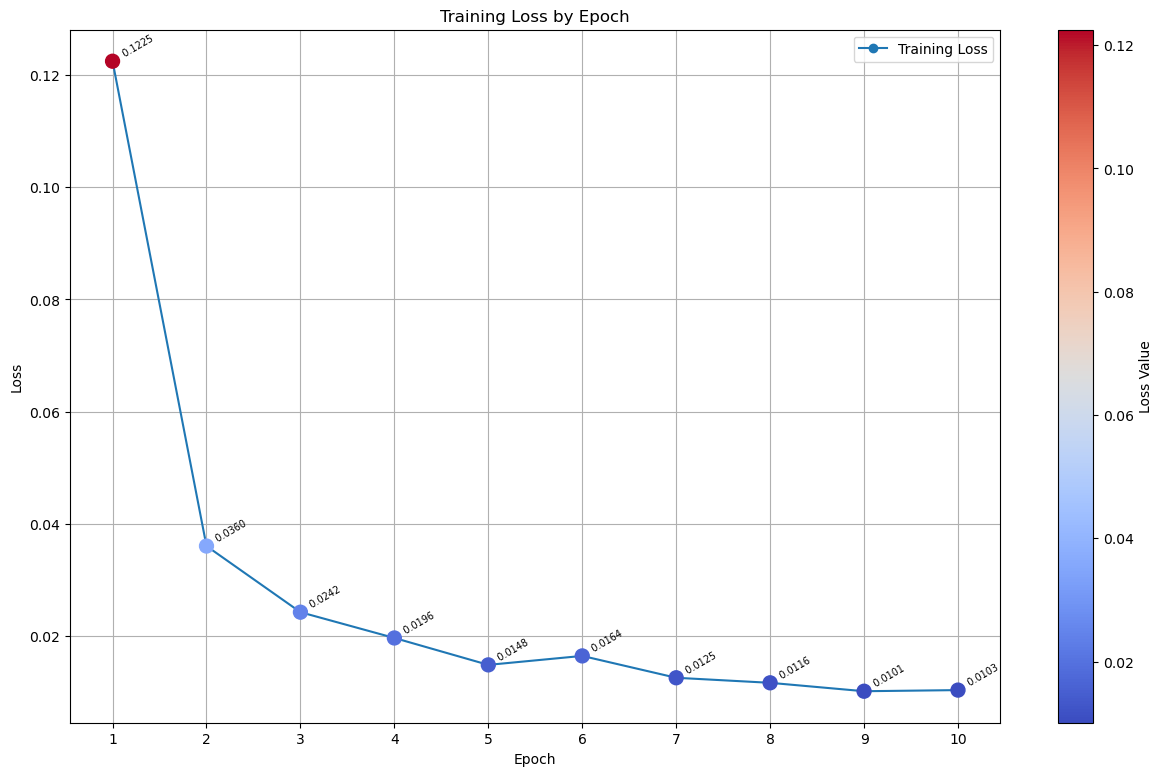

In [5]:
# Now that we have our loss function and optimizer, we are ready to train the model
model.to('cuda') # Declare that we want to train the model using GPU. If you want to train using CPU, replace 'cuda' with 'cpu' 

epochs = 10 # Declare the number of training epochs
loss_values = []
for epoch in range(epochs):
    model.train() # Set the model to training mode
    running_loss = 0.0 # Starting the loss count at zero
    
    # Tell it to iterate over the training set
    for images, labels in train_loader:
        images, labels = images.to('cuda'), labels.to('cuda') # Send the training data to the GPU
        optimizer.zero_grad() # Zeroize the gradients
        outputs = model(images) # Start the forward pass
        loss = criterion(outputs, labels) # Compute the loss
        loss.backward() # Back propogation to train the model on errors made in the previous pass 
        optimizer.step() # Optimize by updating the model parameters based on what was learned
        running_loss += loss.item() * images.size(0) # Update the running_loss count as we go
        
    # Calculate the average loss for each epoch and print it out in real time. This will give live updates while the model is training
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')
    loss_values.append(epoch_loss)

# Finally, print out a message that notifies us that the training has completed
print("The model has finished training. Plotting loss.")

# Round the loss values and create data for the x-axis
loss_values = [round(x, 4) for x in loss_values]
epchs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Normalize loss values to [0, 1] for colormap
norm = plt.Normalize(min(loss_values), max(loss_values))
colors = plt.cm.coolwarm(norm(loss_values))

# Create the figure and the plot lines
plt.figure(figsize=(15, 9))
plt.plot(epchs, loss_values, label="Training Loss", marker="o")

# Use scatter with a colormap for color gradient
scatter = plt.scatter(epchs, loss_values, c=loss_values, cmap='coolwarm', s=100, zorder=2)

# Label each individual epoch's loss
for idx, value in enumerate(loss_values):
    plt.text(epchs[idx], value, f'   {value:.4f}', fontsize=7, ha='left', rotation=30, color='black', zorder=3)

# Plot details
plt.title("Training Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(epchs)
plt.colorbar(scatter, label='Loss Value')
plt.legend()
plt.grid()
plt.show()

In [7]:
# At last, we can test the model's performace on unseen data
model.eval() # Set the model to testing mode
test_loss = 0.0 # set the test loss counter to zero
correct = 0 # Set the correct counter to zero

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to('cuda'), labels.to('cuda') # Send the test data to the GPU
        outputs = model(images) # Start the forward pass
        loss = criterion(outputs, labels) # Compute the loss
        test_loss += loss.item() * images.size(0) # Update the test loss as we go
        _, preds = torch.max(outputs, 1) # torch.max() returns two tensors: _ = the max value in each row (not used), and preds = predicted class
        correct += (preds == labels).sum().item() # (preds == labels) checks if the prediction mathces the label. Match = 1, no match = 0. By summing, we count the number of correct predictions. .item() converts this sum from a tensor to a scalar

test_loss = test_loss / len(test_loader.dataset) # Calculate the total loss
accuracy = correct / len(test_loader.dataset) # Calculate the percentage of correct predctions

# Print off the loss and accuracy of the model when run on unseen data
print(f'Test Loss: {test_loss:.4f}', f'Test Accuracy: {accuracy:.4f}')

Test Loss: 0.0282 Test Accuracy: 0.9932
